In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


In [2]:
# Paths
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")
TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

CONFIG = {
    'image_size': (128, 128),
    'batch_size': 64,
    'num_epochs': 25,
    'learning_rate': 2e-4,
    'patience': 5,
    
    # Multi-scale latent dimensions
    'latent_dims': [64, 128, 192],
    
    # Seeds for ensemble (10 total)
    'seeds': [42, 123, 456, 789, 1024, 2048, 3072, 4096, 5120, 6144],
    
    # Temporal smoothing
    'smooth_sigma': [0, 1, 2, 3],  # 0 = no smoothing
}

print(f"Latent dims: {CONFIG['latent_dims']}")
print(f"Seeds: {len(CONFIG['seeds'])} models")
print(f"Total models: {len(CONFIG['latent_dims'])} x {len(CONFIG['seeds'])} = {len(CONFIG['latent_dims']) * len(CONFIG['seeds'])}")

Latent dims: [64, 128, 192]
Seeds: 10 models
Total models: 3 x 10 = 30


In [3]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)
print(f"Train: {sum(len(v) for v in train_frames.values())} frames")
print(f"Test: {sum(len(v) for v in test_frames.values())} frames")

Train: 9204 frames
Test: 11706 frames


In [4]:
test_frame_ids = []
test_frame_info = []
for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))
print(f"Test IDs: {len(test_frame_ids)}")

Test IDs: 11706


In [5]:
def load_to_gpu(frames_dict, image_size, device):
    total = sum(len(v) for v in frames_dict.values())
    H, W = image_size
    tensors = torch.zeros(total, 3, H, W, dtype=torch.float32, device=device)
    info = []
    idx = 0
    pbar = tqdm(total=total, desc="Loading")
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            img = Image.open(path).convert('RGB').resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32) / 127.5 - 1.0
            tensors[idx] = torch.from_numpy(arr).permute(2, 0, 1)
            info.append((vid, fnum))
            idx += 1
            pbar.update(1)
    pbar.close()
    return tensors, info

print("Loading training data...")
train_tensors, train_info = load_to_gpu(train_frames, CONFIG['image_size'], DEVICE)
print(f"Train: {train_tensors.shape}")

print("\nLoading testing data...")
test_tensors, test_info = load_to_gpu(test_frames, CONFIG['image_size'], DEVICE)
print(f"Test: {test_tensors.shape}")
print(f"GPU: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading training data...


Loading:   0%|          | 0/9204 [00:00<?, ?it/s]

Train: torch.Size([9204, 3, 128, 128])

Loading testing data...


Loading:   0%|          | 0/11706 [00:00<?, ?it/s]

Test: torch.Size([11706, 3, 128, 128])
GPU: 4.11 GB


In [6]:
class SimpleAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True),
        )
        self.fc_enc = nn.Sequential(nn.Flatten(), nn.Linear(512*4*4, latent_dim))
        self.fc_dec = nn.Sequential(nn.Linear(latent_dim, 512*4*4), nn.LeakyReLU(0.2, True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.fc_enc(self.encoder(x))
        return self.decoder(self.fc_dec(z).view(-1, 512, 4, 4))

In [7]:
def train_model(seed, latent_dim, train_tensors, config, device):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    model = SimpleAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    
    loader = DataLoader(TensorDataset(train_tensors), batch_size=config['batch_size'], shuffle=True)
    
    best_loss = float('inf')
    patience = 0
    best_state = None
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        for (batch,) in loader:
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(batch), batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        if avg_loss < best_loss - 1e-5:
            best_loss = avg_loss
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1
        
        if patience >= config['patience']:
            break
    
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_loss

In [8]:
print("=" * 60)
print("TRAINING LARGE ENSEMBLE")
print("=" * 60)

# We'll train a strategic subset to save time
# 3 latent dims x 3-4 seeds each = 9-12 models
TRAINING_PLAN = [
    # (latent_dim, seeds)
    (64, [42, 123, 456]),       # Tight bottleneck
    (128, [42, 123, 456, 789]), # Medium (proven to work)
    (192, [42, 123, 456]),      # Looser
]

all_models = []
all_configs = []

for latent_dim, seeds in TRAINING_PLAN:
    print(f"\n--- Latent dim: {latent_dim} ---")
    for seed in seeds:
        print(f"  Training seed={seed}...", end=" ")
        start = time.time()
        model, loss = train_model(seed, latent_dim, train_tensors, CONFIG, DEVICE)
        elapsed = time.time() - start
        print(f"loss={loss:.5f}, time={elapsed:.1f}s")
        
        all_models.append(model)
        all_configs.append({'latent_dim': latent_dim, 'seed': seed, 'loss': loss})

print(f"\nTrained {len(all_models)} models")

TRAINING LARGE ENSEMBLE

--- Latent dim: 64 ---
  Training seed=42... loss=0.00224, time=208.3s
  Training seed=123... loss=0.00235, time=203.7s
  Training seed=456... loss=0.00234, time=204.0s

--- Latent dim: 128 ---
  Training seed=42... loss=0.00211, time=205.3s
  Training seed=123... loss=0.00215, time=205.3s
  Training seed=456... loss=0.00221, time=205.5s
  Training seed=789... loss=0.00220, time=205.4s

--- Latent dim: 192 ---
  Training seed=42... loss=0.00211, time=207.0s
  Training seed=123... loss=0.00204, time=207.2s
  Training seed=456... loss=0.00206, time=207.0s

Trained 10 models


In [9]:
@torch.no_grad()
def get_max_scores(model, tensors, frame_info, batch_size=128):
    model.eval()
    scores = {}
    for start in range(0, len(tensors), batch_size):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        max_err = torch.amax((batch - recon) ** 2, dim=(1, 2, 3))
        for i, s in enumerate(max_err.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(s)
    return scores

print("Computing scores from all models...")
all_scores = []
for i, model in enumerate(all_models):
    cfg = all_configs[i]
    print(f"  Model {i+1}: latent={cfg['latent_dim']}, seed={cfg['seed']}")
    scores = get_max_scores(model, test_tensors, test_info)
    all_scores.append(scores)
print(f"Done! {len(all_scores)} score sets")

Computing scores from all models...
  Model 1: latent=64, seed=42
  Model 2: latent=64, seed=123
  Model 3: latent=64, seed=456
  Model 4: latent=128, seed=42
  Model 5: latent=128, seed=123
  Model 6: latent=128, seed=456
  Model 7: latent=128, seed=789
  Model 8: latent=192, seed=42
  Model 9: latent=192, seed=123
  Model 10: latent=192, seed=456
Done! 10 score sets


In [10]:
def normalize(scores, clip_pct=99):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    clip_val = np.percentile(vals, clip_pct)
    vals = np.clip(vals, 0, clip_val)
    v_min, v_max = vals.min(), vals.max()
    if v_max > v_min:
        norm = (vals - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals) * 0.5
    return {k: float(norm[i]) for i, k in enumerate(keys)}

def ensemble_mean(score_list):
    keys = list(score_list[0].keys())
    return {k: np.mean([s[k] for s in score_list]) for k in keys}

# Normalize all scores
all_norm = [normalize(s) for s in all_scores]
print("Normalized all scores")

Normalized all scores


In [11]:
def temporal_smooth(scores, test_frames, video_fnums, sigma):
    """Apply Gaussian smoothing within each video."""
    if sigma == 0:
        return scores.copy()
    
    smoothed = {}
    
    for vid in sorted(test_frames.keys()):
        fnums = sorted([f[0] for f in test_frames[vid]])
        vals = np.array([scores.get(f"{vid}_{fn}", 0) for fn in fnums])
        
        if len(vals) > 1:
            vals_smooth = gaussian_filter1d(vals, sigma=sigma)
        else:
            vals_smooth = vals
        
        for i, fn in enumerate(fnums):
            smoothed[f"{vid}_{fn}"] = float(vals_smooth[i])
    
    return smoothed

# Build video fnums lookup
test_video_fnums = defaultdict(list)
for vid, fnum in test_info:
    test_video_fnums[vid].append(fnum)
for vid in test_video_fnums:
    test_video_fnums[vid] = sorted(set(test_video_fnums[vid]))

In [12]:
# Create different ensemble combinations
ensembles = {}

# 1. All models ensemble
all_ensemble = normalize(ensemble_mean(all_norm), clip_pct=100)
ensembles['all_models'] = all_ensemble

# 2. Best latent dim only (128)
latent128_idx = [i for i, c in enumerate(all_configs) if c['latent_dim'] == 128]
latent128_scores = [all_norm[i] for i in latent128_idx]
ensembles['latent128_only'] = normalize(ensemble_mean(latent128_scores), clip_pct=100)

# 3. Tight bottleneck (64)
latent64_idx = [i for i, c in enumerate(all_configs) if c['latent_dim'] == 64]
latent64_scores = [all_norm[i] for i in latent64_idx]
ensembles['latent64_only'] = normalize(ensemble_mean(latent64_scores), clip_pct=100)

# 4. Combine 64 + 128 (skip 192)
combined_idx = [i for i, c in enumerate(all_configs) if c['latent_dim'] in [64, 128]]
combined_scores = [all_norm[i] for i in combined_idx]
ensembles['latent64_128'] = normalize(ensemble_mean(combined_scores), clip_pct=100)

print(f"Created {len(ensembles)} base ensembles")

Created 4 base ensembles


In [13]:
# Apply temporal smoothing to best ensemble
base_ensemble = ensembles['all_models']

for sigma in CONFIG['smooth_sigma']:
    if sigma == 0:
        ensembles['all_smooth0'] = base_ensemble
    else:
        smoothed = temporal_smooth(base_ensemble, test_frames, test_video_fnums, sigma)
        ensembles[f'all_smooth{sigma}'] = normalize(smoothed, clip_pct=100)

print(f"Total ensembles: {len(ensembles)}")

Total ensembles: 8


In [14]:
def save_sub(scores, filename):
    df = pd.DataFrame([{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in test_frame_ids])
    df.to_csv(os.path.join(OUTPUT_DIR, filename), index=False)
    print(f"Saved: {filename}")
    return df

print("Generating submissions...")
print("-" * 40)

submissions = {}
for name, scores in ensembles.items():
    submissions[name] = save_sub(scores, f'sub_{name}.csv')

print("-" * 40)
print(f"Generated {len(submissions)} submissions")

Generating submissions...
----------------------------------------
Saved: sub_all_models.csv
Saved: sub_latent128_only.csv
Saved: sub_latent64_only.csv
Saved: sub_latent64_128.csv
Saved: sub_all_smooth0.csv
Saved: sub_all_smooth1.csv
Saved: sub_all_smooth2.csv
Saved: sub_all_smooth3.csv
----------------------------------------
Generated 8 submissions


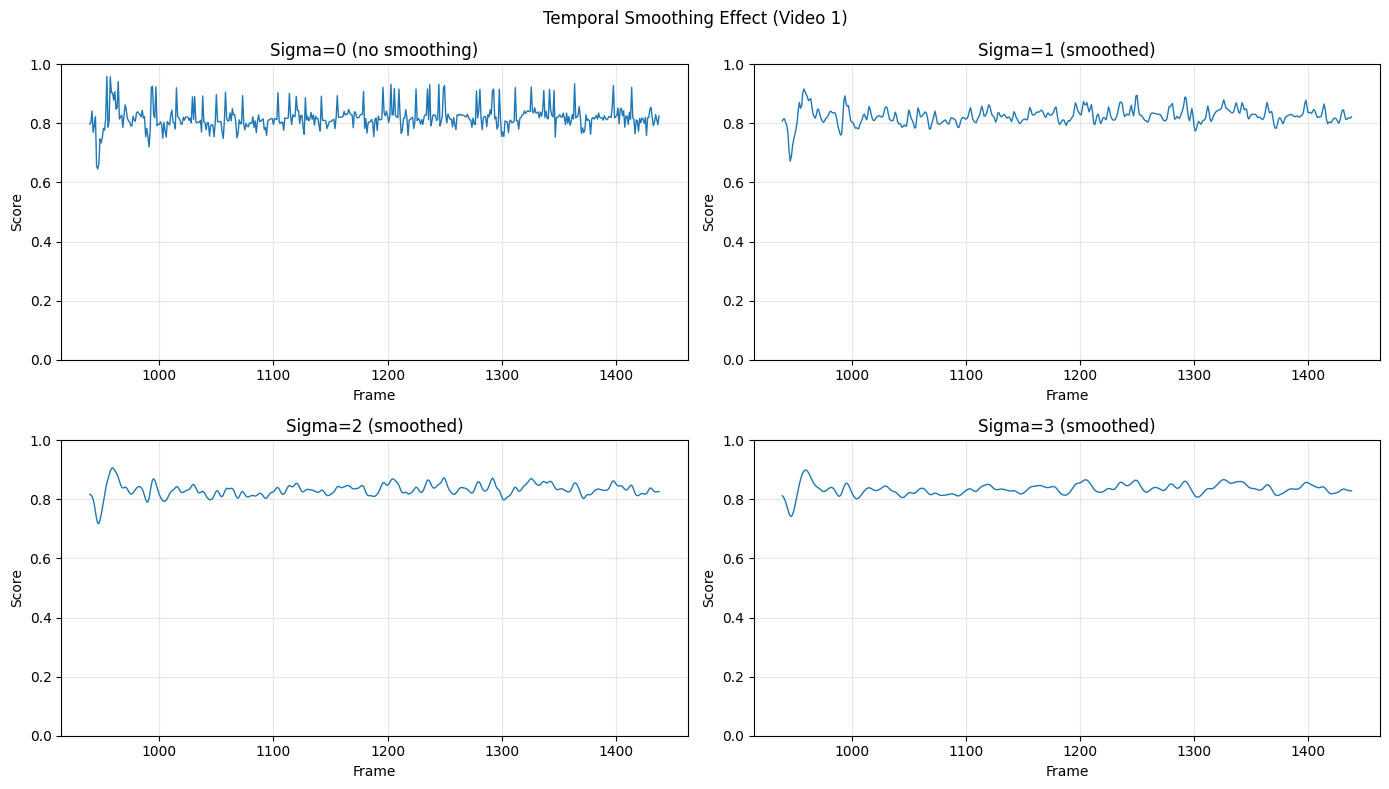

In [15]:
# Visualize smoothing effect
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sample_vid = sorted(test_frames.keys())[0]
fnums = [f[0] for f in test_frames[sample_vid]]

for idx, sigma in enumerate(CONFIG['smooth_sigma']):
    ax = axes[idx // 2, idx % 2]
    key = f'all_smooth{sigma}'
    vals = [ensembles[key].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
    ax.plot(fnums, vals, linewidth=1)
    ax.set_title(f'Sigma={sigma} ({"no smoothing" if sigma==0 else "smoothed"})')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Score')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Temporal Smoothing Effect (Video {sample_vid})')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'smoothing_effect.png'))
plt.show()

In [16]:
# Compare latent dim performance
print("Individual model losses by latent dim:")
for latent_dim in [64, 128, 192]:
    losses = [c['loss'] for c in all_configs if c['latent_dim'] == latent_dim]
    print(f"  Latent {latent_dim}: mean={np.mean(losses):.5f}, std={np.std(losses):.5f}")

Individual model losses by latent dim:
  Latent 64: mean=0.00231, std=0.00005
  Latent 128: mean=0.00217, std=0.00004
  Latent 192: mean=0.00207, std=0.00003


In [17]:
# Cleanup
del train_tensors, test_tensors, all_models
gc.collect()
torch.cuda.empty_cache()
print("Done!")

Done!
